In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
import time
from collections import defaultdict

# 强制设置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可重现
np.random.seed(42)

In [12]:
class AnnoyTreeNode:
    """Annoy树的节点"""
    
    def __init__(self, indices):
        """
        初始化节点
        
        参数:
        - indices: 当前节点包含的向量索引列表
        """
        self.indices = indices  # 当前节点包含的向量索引
        self.left = None  # 左子树
        self.right = None  # 右子树
        
        # 分割超平面参数
        self.split_vector1 = None  # 第一个锚点向量
        self.split_vector2 = None  # 第二个锚点向量
        self.split_point = None  # 中点
        self.split_normal = None  # 法向量
        
        self.is_leaf = False  # 是否为叶子节点

In [13]:
class SimpleAnnoy:
    """简化的Annoy实现，用于学习演示"""
    
    def __init__(self, n_trees=5, max_leaf_size=10):
        """
        初始化Annoy索引
        
        参数:
        - n_trees: 构建的树的数量
        - max_leaf_size: 叶子节点最大包含的向量数
        """
        self.n_trees = n_trees
        self.max_leaf_size = max_leaf_size
        self.trees = []  # 存储所有的树
        self.data_points = []  # 存储所有数据点
        
    def _build_tree(self, indices, data, depth=0, max_depth=20):
        """
        递归构建单棵Annoy树
        
        参数:
        - indices: 当前节点包含的向量索引
        - data: 所有数据点
        - depth: 当前深度
        - max_depth: 最大深度
        """
        node = AnnoyTreeNode(indices)
        
        # 停止条件：节点包含的向量数量小于阈值或达到最大深度
        if len(indices) <= self.max_leaf_size or depth >= max_depth:
            node.is_leaf = True
            return node
        
        # 随机选择两个不同的向量作为锚点
        if len(indices) < 2:
            node.is_leaf = True
            return node
            
        idx1, idx2 = np.random.choice(indices, size=2, replace=False)
        v1, v2 = data[idx1], data[idx2]
        
        # 如果两个向量相同，直接返回叶子节点
        if np.allclose(v1, v2):
            node.is_leaf = True
            return node
        
        # 计算分割超平面
        node.split_vector1 = v1
        node.split_vector2 = v2
        node.split_point = (v1 + v2) / 2  # 中点
        node.split_normal = v1 - v2  # 法向量
        
        # 根据向量在超平面的哪一侧进行分割
        left_indices = []
        right_indices = []
        
        for idx in indices:
            vec = data[idx]
            # 计算向量到中点的向量与法向量的点积
            # 如果点积 > 0，说明在v1一侧；否则在v2一侧
            projection = np.dot(vec - node.split_point, node.split_normal)
            if projection >= 0:
                left_indices.append(idx)
            else:
                right_indices.append(idx)
        
        # 如果分割后某一侧为空，说明分割失败，返回叶子节点
        if len(left_indices) == 0 or len(right_indices) == 0:
            node.is_leaf = True
            return node
        
        # 递归构建左右子树
        node.left = self._build_tree(left_indices, data, depth + 1, max_depth)
        node.right = self._build_tree(right_indices, data, depth + 1, max_depth)
        
        return node
    
    def build_index(self, data):
        """
        构建Annoy索引（森林）
        
        参数:
        - data: 数据点数组
        """
        self.data_points = np.array(data)
        n_samples = len(self.data_points)
        
        print(f"开始构建{self.n_trees}棵树...")
        
        # 构建多棵树
        for i in range(self.n_trees):
            # 每棵树使用所有数据点，但随机种子不同
            np.random.seed(i + 42)  # 不同的随机种子
            tree = self._build_tree(list(range(n_samples)), self.data_points)
            self.trees.append(tree)
            
            if (i + 1) % max(1, self.n_trees // 2) == 0 or i == self.n_trees - 1:
                print(f"已构建{i + 1}/{self.n_trees}棵树")
        
        print("索引构建完成！")
    
    def _search_tree(self, tree, query, search_k=None):
        """
        在单棵树中搜索
        
        参数:
        - tree: 树的根节点
        - query: 查询向量
        - search_k: 搜索的节点数量限制
        
        返回:
        - 候选向量的索引列表
        """
        candidates = []
        nodes_to_visit = [tree]
        nodes_visited = 0
        
        while nodes_to_visit:
            # 如果设置了search_k限制，检查是否已访问足够多的节点
            if search_k is not None and nodes_visited >= search_k:
                break
            
            node = nodes_to_visit.pop(0)
            nodes_visited += 1
            
            if node.is_leaf:
                # 到达叶子节点，收集所有向量索引
                candidates.extend(node.indices)
            else:
                # 内部节点，判断查询向量在哪一侧
                projection = np.dot(query - node.split_point, node.split_normal)
                if projection >= 0:
                    # 在左侧
                    if node.left:
                        nodes_to_visit.append(node.left)
                else:
                    # 在右侧
                    if node.right:
                        nodes_to_visit.append(node.right)
        
        return candidates
    
    def search(self, query, k=5, search_k=None):
        """
        搜索最近邻
        
        参数:
        - query: 查询向量
        - k: 返回的最近邻数量
        - search_k: 每棵树搜索的节点数量限制（None表示不限制）
        
        返回:
        - 最近邻的索引和距离列表
        """
        if len(self.trees) == 0:
            raise ValueError("索引未构建，请先调用build_index")
        
        # 在所有树中搜索，合并候选集
        all_candidates = set()
        for tree in self.trees:
            candidates = self._search_tree(tree, query, search_k)
            all_candidates.update(candidates)
        
        # 计算所有候选向量与查询向量的真实距离
        candidate_list = list(all_candidates)
        if not candidate_list:
            return [], []
        
        distances = euclidean_distances([query], self.data_points[candidate_list])[0]
        
        # 按距离排序，返回前k个
        sorted_indices = np.argsort(distances)[:k]
        result_indices = [candidate_list[i] for i in sorted_indices]
        result_distances = distances[sorted_indices]
        
        return result_indices, result_distances
    
    def brute_force_search(self, query, k=5):
        """暴力搜索作为对比基准"""
        distances = euclidean_distances([query], self.data_points)[0]
        nearest_indices = np.argsort(distances)[:k]
        return nearest_indices, distances[nearest_indices]

In [14]:
def generate_sample_data(n_samples=200, dim=2):
    """生成示例数据：四个分离的高斯分布簇"""
    # 创建四个簇
    cluster1 = np.random.normal(loc=[2, 2], scale=0.3, size=(n_samples//4, dim))
    cluster2 = np.random.normal(loc=[8, 3], scale=0.4, size=(n_samples//4, dim))
    cluster3 = np.random.normal(loc=[5, 8], scale=0.35, size=(n_samples//4, dim))
    cluster4 = np.random.normal(loc=[3, 6], scale=0.4, size=(n_samples - 3*(n_samples//4), dim))
    
    data = np.vstack([cluster1, cluster2, cluster3, cluster4])
    return data

In [17]:
def demonstrate_annoy_performance():
    """演示Annoy性能对比 - 使用更大规模、更高维度的数据"""
    print("=" * 60)
    print("Annoy算法性能演示")
    print("=" * 60)
    
    # 生成大规模测试数据（保持簇状分布）
    data = generate_sample_data(100000, 2)
    print(f"生成{len(data)}个二维数据点")
    
    # 创建Annoy索引
    annoy = SimpleAnnoy(n_trees=10, max_leaf_size=10)
    
    # 构建索引
    print("\n构建Annoy索引...")
    start_time = time.time()
    annoy.build_index(data)
    construction_time = time.time() - start_time
    print(f"Annoy索引构建完成，耗时: {construction_time:.4f}秒")
    
    # 选择查询点
    query_point = np.array([5.0, 5.0])
    print(f"\n查询点: {query_point}")
    
    # 使用Annoy搜索
    start_time = time.time()
    annoy_results, annoy_distances = annoy.search(query_point, k=5, search_k=100)
    annoy_time = time.time() - start_time
    
    # 暴力搜索作为基准
    start_time = time.time()
    bf_indices, bf_distances = annoy.brute_force_search(query_point, k=5)
    bf_time = time.time() - start_time
    
    # 显示结果对比
    print(f"\n搜索结果对比:")
    print(f"Annoy搜索 - 找到{len(annoy_results)}个最近邻, 耗时: {annoy_time:.6f}秒")
    print(f"暴力搜索 - 找到{len(bf_indices)}个最近邻, 耗时: {bf_time:.6f}秒")
    
    print(f"\n速度提升: {bf_time/annoy_time:.2f}倍")
    
    print(f"\nAnnoy结果索引: {annoy_results}")
    print(f"Annoy结果距离: {annoy_distances}")
    print(f"暴力搜索结果索引: {bf_indices.tolist()}")
    print(f"暴力搜索结果距离: {bf_distances}")
    
    # 检查召回率
    annoy_indices_set = set(annoy_results)
    bf_indices_set = set(bf_indices)
    intersection = annoy_indices_set & bf_indices_set
    recall = len(intersection) / len(bf_indices_set)
    print(f"召回率: {recall:.2%} ({len(intersection)}/{len(bf_indices_set)})")
    
    return annoy, data, query_point, annoy_results, bf_indices

# 运行标准演示
annoy, data, query, annoy_results, bf_results = demonstrate_annoy_performance()

Annoy算法性能演示
生成100000个二维数据点

构建Annoy索引...
开始构建10棵树...
已构建5/10棵树
已构建10/10棵树
索引构建完成！
Annoy索引构建完成，耗时: 38.9665秒

查询点: [5. 5.]

搜索结果对比:
Annoy搜索 - 找到5个最近邻, 耗时: 0.002012秒
暴力搜索 - 找到5个最近邻, 耗时: 0.016312秒

速度提升: 8.11倍

Annoy结果索引: [76568, 87053, 99758, 86413, 85476]
Annoy结果距离: [0.67309842 0.71583121 0.76414983 0.80066059 0.85234455]
暴力搜索结果索引: [76568, 87053, 99758, 86413, 85476]
暴力搜索结果距离: [0.67309842 0.71583121 0.76414983 0.80066059 0.85234455]
召回率: 100.00% (5/5)


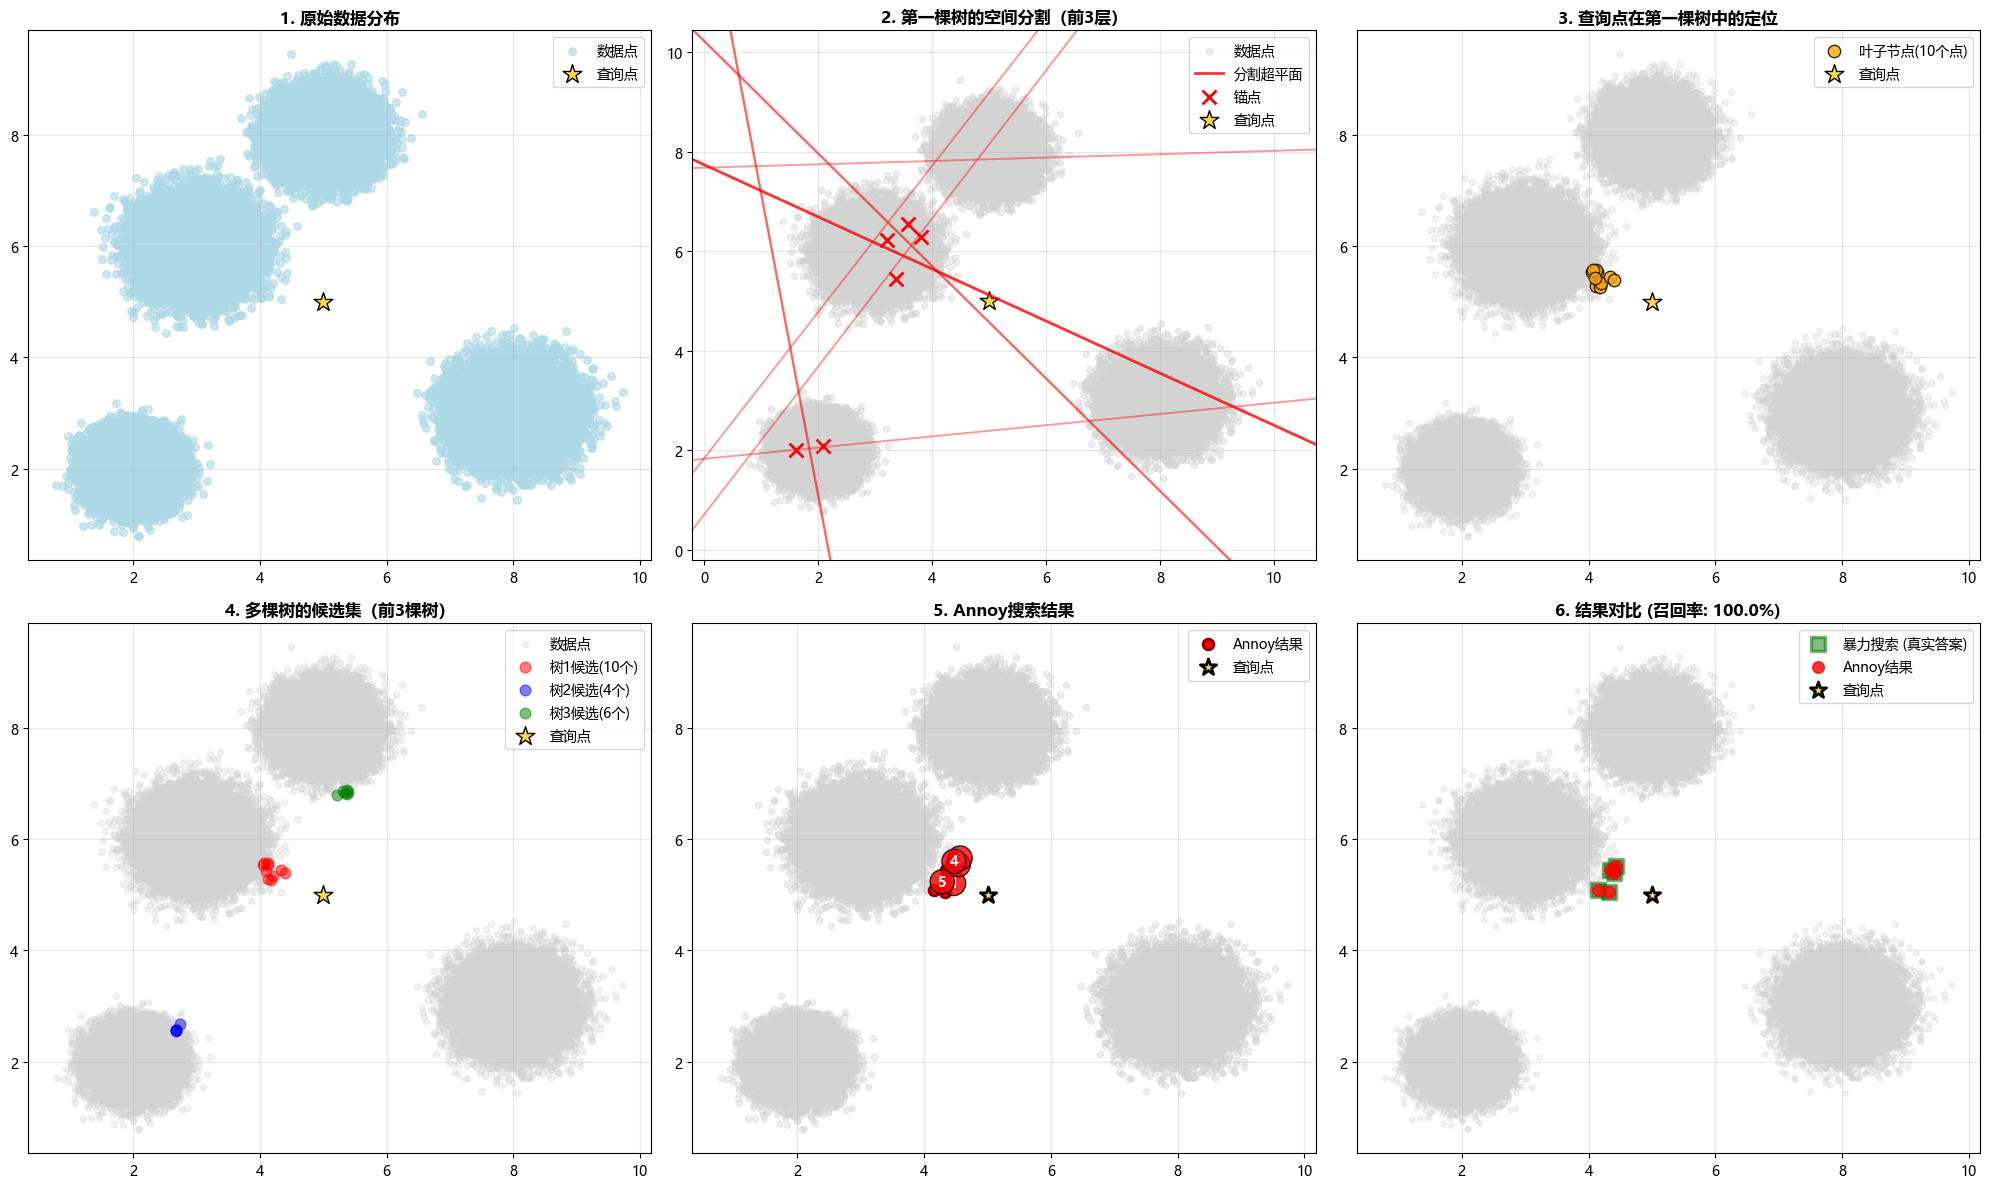

In [18]:
def visualize_annoy(annoy, data, query_point, annoy_results, bf_results):
    """可视化Annoy算法"""
    fig = plt.figure(figsize=(20, 12))
    
    # 1. 原始数据分布
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.scatter(data[:, 0], data[:, 1], c='lightblue', alpha=0.6, s=30, label='数据点')
    ax1.scatter(query_point[0], query_point[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', label='查询点')
    ax1.set_title('1. 原始数据分布', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 第一棵树的空间分割（可视化前几层）
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.4, s=20, label='数据点')
    
    # 可视化第一棵树的分割超平面（只显示前几层）
    def plot_splits(node, depth=0, max_depth=3):
        if node is None or node.is_leaf or depth >= max_depth:
            return
        
        # 绘制分割线（2D情况下）
        if node.split_normal is not None:
            # 分割线垂直于法向量，过中点
            mid = node.split_point
            normal = node.split_normal
            
            # 计算分割线的方向向量（垂直于法向量）
            if abs(normal[1]) > 1e-10:
                direction = np.array([1, -normal[0] / normal[1]])
            else:
                direction = np.array([0, 1])
            
            # 归一化方向向量
            direction = direction / np.linalg.norm(direction)
            
            # 绘制分割线
            line_length = 15
            x_vals = [mid[0] - line_length * direction[0], mid[0] + line_length * direction[0]]
            y_vals = [mid[1] - line_length * direction[1], mid[1] + line_length * direction[1]]
            
            alpha = 0.8 - depth * 0.2
            ax2.plot(x_vals, y_vals, 'r-', alpha=max(alpha, 0.3), linewidth=2-depth*0.3,
                    label='分割超平面' if depth == 0 else '')
            
            # 标注锚点
            if depth < 2:
                ax2.scatter([node.split_vector1[0], node.split_vector2[0]], 
                           [node.split_vector1[1], node.split_vector2[1]], 
                           c='red', marker='x', s=100, linewidths=2,
                           label='锚点' if depth == 0 else '')
        
        # 递归绘制子树的分割
        plot_splits(node.left, depth + 1, max_depth)
        plot_splits(node.right, depth + 1, max_depth)
    
    plot_splits(annoy.trees[0])
    ax2.scatter(query_point[0], query_point[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', label='查询点')
    ax2.set_title('2. 第一棵树的空间分割（前3层）', fontweight='bold')
    
    # 去重图例
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(data[:, 0].min() - 1, data[:, 0].max() + 1)
    ax2.set_ylim(data[:, 1].min() - 1, data[:, 1].max() + 1)
    
    # 3. 树的遍历路径
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.3, s=20)
    
    # 在第一棵树中找到查询点的路径
    def find_path_in_tree(node, query):
        path = [node]
        current = node
        while not current.is_leaf:
            projection = np.dot(query - current.split_point, current.split_normal)
            if projection >= 0 and current.left:
                current = current.left
            elif current.right:
                current = current.right
            else:
                break
            path.append(current)
        return path
    
    path = find_path_in_tree(annoy.trees[0], query_point)
    leaf_node = path[-1]
    
    # 高亮叶子节点中的点
    if leaf_node.is_leaf:
        leaf_indices = leaf_node.indices
        ax3.scatter(data[leaf_indices, 0], data[leaf_indices, 1], 
                   c='orange', s=80, alpha=0.8, edgecolors='black',
                   label=f'叶子节点({len(leaf_indices)}个点)')
    
    ax3.scatter(query_point[0], query_point[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', label='查询点')
    ax3.set_title('3. 查询点在第一棵树中的定位', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 多棵树的候选集合并
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.3, s=20, label='数据点')
    
    # 收集所有树的候选点
    all_tree_candidates = []
    for i, tree in enumerate(annoy.trees[:min(3, len(annoy.trees))]):  # 只显示前3棵树
        candidates = annoy._search_tree(tree, query_point)
        all_tree_candidates.append(candidates)
        
        # 用不同颜色显示不同树的候选点
        colors_map = ['red', 'blue', 'green']
        ax4.scatter(data[candidates, 0], data[candidates, 1], 
                   c=colors_map[i], s=60, alpha=0.5, 
                   label=f'树{i+1}候选({len(candidates)}个)')
    
    ax4.scatter(query_point[0], query_point[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', label='查询点')
    ax4.set_title(f'4. 多棵树的候选集（前3棵树）', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Annoy搜索结果
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.4, s=20)
    ax5.scatter(data[annoy_results, 0], data[annoy_results, 1], 
               c='red', marker='o', s=60, edgecolors='darkred', 
               linewidth=2, label='Annoy结果')
    
    # 标注排名
    for i, idx in enumerate(annoy_results[:5]):
        ax5.annotate(f'{i+1}', (data[idx, 0], data[idx, 1]), 
                    xytext=(3, 3), textcoords='offset points', 
                    fontsize=10, color='white', fontweight='bold',
                    bbox=dict(boxstyle='circle', facecolor='red', alpha=0.8))
    
    ax5.scatter(query_point[0], query_point[1], c='#FFD93D', marker='*', s=150, 
               edgecolors='black', linewidth=2, label='查询点')
    ax5.set_title('5. Annoy搜索结果', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. 结果对比
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.3, s=15)
    
    # 暴力搜索结果
    ax6.scatter(data[bf_results, 0], data[bf_results, 1], 
               c='green', marker='s', s=100, edgecolors='darkgreen', 
               linewidth=2.5, label='暴力搜索 (真实答案)', alpha=0.5)
    
    # Annoy结果
    ax6.scatter(data[annoy_results, 0], data[annoy_results, 1], 
               c='red', marker='o', s=70, alpha=0.8, label='Annoy结果')
    
    # 查询点
    ax6.scatter(query_point[0], query_point[1], c='#FFD93D', marker='*', s=150, 
               edgecolors='black', linewidth=2, label='查询点')
    
    # 计算召回率
    intersection = set(annoy_results) & set(bf_results)
    recall = len(intersection) / len(bf_results)
    
    ax6.set_title(f'6. 结果对比 (召回率: {recall:.1%})', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 调用可视化
visualize_annoy(annoy, data, query, annoy_results, bf_results)

## 完成！

Annoy 算法演示结束。你可以尝试调整以下参数来观察效果：
- `n_trees`: 树的数量（越多召回率越高，但构建和查询时间增加）
- `search_k`: 搜索时访问的节点数（越大召回率越高，但查询时间增加）
- `max_leaf_size`: 叶子节点最大向量数（影响树的深度和查询精度）